[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/azad-academy/denoising-diffusion-model/blob/main/diffusion_model_demo.ipynb)

## Learning Channel Distribution by Diffusion Models
 
This notebook file is a framework to learn channels by their conditional distributions: the distirubtions of the channel output for given channel inputs. To serve that, we edited a standard 1-dimensional U-Net to be conditional on the channel input. For the channel model, we used a correlated Rayleigh fading model.

In [15]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import torch
#import tqdm as notebook_tqdm
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import importlib
import sys
sys.path.append('src/')

# Import modules from own libraries
from denoising_diffusion_pytorch_1d_cond import GaussianDiffusion1D, Unet1D, Trainer1D, Dataset1D
import channel_models
import WGAN

# Set the writer
writer_G = SummaryWriter("runs/wgan_G_cnn1")
writer_D = SummaryWriter("runs/wgan_D_cnn1")

# Set the device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Set the path for saving and loading models
path = 'state_dict_WGAN_CNN'

## Choose channel model and diffusion model type

In [16]:
channel_model_str = 'corrRayleigh' #available options: AWGN, Rayleigh, SSPA

## Channel model settings

In [17]:
def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

class Channel_Config:
    def __init__(self, channel_model_str, blocklength, training_noise_std, device="cpu", f_dopp_norm=None):
        super().__init__()
        self.channel_model_str = channel_model_str
        self.blocklength = blocklength
        self.training_noise_std = training_noise_std
        self.device = device
        self.f_dopp_norm = f_dopp_norm
        self.cov = channel_models.Rayleigh_covariance_generator(n, f_dopp_norm,
                                                 dtype_cov=torch.cfloat) if f_dopp_norm is not None else None

    def channel_model_fn(self):
        channel_model_str = self.channel_model_str
        if channel_model_str == 'AWGN':
            channel_model = channel_models.ch_AWGN
        elif channel_model_str == 'Rayleigh':
            channel_model = channel_models.ch_Rayleigh_AWGN_n
        elif channel_model_str == 'SSPA':
            channel_model = channel_models.ch_SSPA
        elif channel_model_str == 'corrRayleigh':
            assert f_dopp_norm is not None, 'The normalized doppler frequency, f_dopp_norm, is not given.'
            cov = self.cov
            channel_model = partial(channel_models.ch_corr_Rayleigh_by_cov, Cov_h=cov)
        else:
            raise Exception("Unrecognized channel model. Possible channel models: AWGN, Rayleigh, SSPA.")
        self.channel_model = channel_model
        return channel_model

    def show_cov(self):
        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(self.cov.real, cmap='hot', )  # , interpolation='nearest')
        ax.set_title(r'Covariance, $\bar{f}_D=' + str(self.f_dopp_norm) + '$')
        plt.colorbar(im, ax=ax, fraction=0.046)
        plt.savefig(f'figures/cov_fD={self.f_dopp_norm:.3f}.pdf')
        plt.show()


In [18]:
def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

In [19]:
def generate_training_seq(dataset_size, Config_ch, batch_size = 100):
    n = Config_ch.blocklength
    training_seq = torch.zeros(dataset_size, 2*2, n)
    idx = 0
    for i, batch in enumerate(torch.split(training_seq, batch_size)):
        bs = batch.shape[0]
        
        training_x = torch.randn(bs, n, dtype=torch.cfloat)
        channel_model = Config_ch.channel_model_fn()
        training_y = channel_model(training_x, Config_ch.training_noise_std, Config_ch.device)
        training_x = torch.transpose(torch.view_as_real(training_x), 1, 2)
        training_y = torch.transpose(torch.view_as_real(training_y), 1, 2)
        training_seq[idx:idx+bs, :, :] = torch.cat((training_y, training_x), dim=1)
        idx += bs
    return training_seq

In [20]:
def compare_empirical_cov(model_G, Config_ch, num_samples = 10 **3, milestone=0):
    # y = Hx = h, when H = diag(h) and x = (1,1,1,...,1,1)^T. 
    ## For such channel input, generative network can generate the channel state information h.
    device = Config_ch.device
    ## Sample the channel coefficients by using the identity channel input. 
    condition_ones = torch.ones([bs, n], dtype=torch.cfloat, device=device)
    condition_ones = torch.transpose(torch.view_as_real(condition_ones), 1,2).contiguous()

    generated_h = torch.zeros([num_samples, 2, n])
    for it in range(num_samples//bs):
        generated_h[it*bs:(it+1)*bs,:, :] = model_G(condition_ones).detach().cpu()
    generated_h_t = torch.transpose(generated_h, 1,2)
    generated_h_t = generated_h_t.contiguous() # After taking transpose, it's necessary. 
    h_gen = torch.view_as_complex(generated_h_t)
    
    cov_emp = torch.cov(h_gen.T).detach().cpu().numpy()
    idx = np.arange(n)    
    cov_emp[idx, idx] -= 2*noise_std ** 2
    
    fig_cov_comparison, [ax1, ax2] = plt.subplots(1,2)
    im1 = ax1.imshow(Config_ch.cov.real, cmap='hot') # , interpolation='nearest')
    ax1.set_title('defined cov.')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    im2 = ax2.imshow(cov_emp.real, cmap='hot')#, interpolation='nearest')
    ax2.set_title('emp. cov.')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    fig_cov_comparison.suptitle(
        r'$\bar{f}_{D}$'+f'={Config_ch.f_dopp_norm}, # of Samples={num_samples}', y=0.9)
    fig_cov_comparison.tight_layout()
    plt.savefig(f'figures/emp_cov_CNN-WGAN_fD_{f_dopp_norm:.3f}_ns{num_samples}_ms{milestone}.pdf')
    
    return generated_h

In [ ]:
def plot_emp_cov(model_G, Config_ch, num_samples = 10 **3, milestone=0):
    # y = Hx = h, when H = diag(h) and x = (1,1,1,...,1,1)^T. 
    ## For such channel input, generative network can generate the channel state information h.
    device = Config_ch.device
    ## Sample the channel coefficients by using the identity channel input. 
    condition_ones = torch.ones([num_samples, n], dtype=torch.cfloat, device=device)
    condition_ones = torch.transpose(torch.view_as_real(condition_ones), 1,2).contiguous()
    generated_h = model_G(condition_ones)

    generated_h_t = torch.transpose(generated_h, 1,2)
    generated_h_t = generated_h_t.contiguous() # After taking transpose, it's necessary. 
    h_gen = torch.view_as_complex(generated_h_t)
    
    cov_emp = torch.cov(h_gen.T).detach().cpu().numpy()
    idx = np.arange(n)    
    cov_emp[idx, idx] -= 2*noise_std ** 2
    
    fig_cov = plt.figure(figsize=(3,3))
    im = plt.imshow(cov_emp.real, cmap='hot')#, interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    fig_cov.tight_layout()
    plt.savefig(f'figures/emp_cov_CNN-WGAN_ms{milestone}.pdf', bbox_inches='tight')
    plt.show()
    return generated_h

In [21]:
# Channel Model
n = 128  # Block length
f_dopp_norm = 0.01
TRAINING_SNR = 15 # decibel
noise_std = SNR_to_noise(TRAINING_SNR)
Config_ch = Channel_Config(channel_model_str, n, noise_std, device=device, f_dopp_norm=f_dopp_norm)

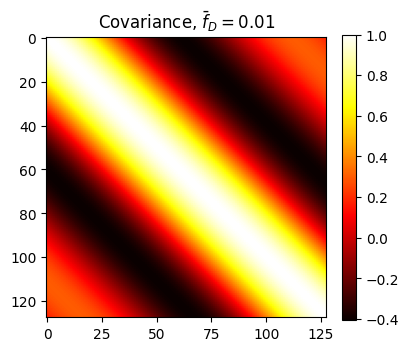

In [22]:
Config_ch.show_cov()

In [23]:
channel_fn = Config_ch.channel_model_fn()

In [24]:
channel_model = partial(channel_fn, AWGN_std=noise_std, device =device)

In [25]:
def _sort_rows(matrix, num_rows):
  """Sort matrix rows by the last column.

  Args:
      matrix: a matrix of values (row,col).
      num_rows: (int) number of sorted rows to return from the matrix.

  Returns:
      Tensor (num_rows, col) of the sorted matrix top K rows.
  """
  tmatrix = torch.transpose(matrix, 1, 0) 
  sorted_matrix = torch.topk(tmatrix, k=num_rows)[0] #tf.nn.top_k(tmatrix, num_rows)[0]
  return torch.transpose(sorted_matrix, 1, 0) 

def _sliced_wasserstein(a, b, random_sampling_count, random_projection_dim=1):
  """Compute the approximate sliced Wasserstein distance.

  Args:
      a: (matrix) Distribution "a" of samples (row, col).
      b: (matrix) Distribution "b" of samples (row, col).
      random_sampling_count: (int) Number of random projections to average.
      random_projection_dim: (int) Dimension of the random projection space.

  Returns:
      Float containing the approximate distance between "a" and "b".
  """
  s = a.shape #tf.shape(input=a)
  means = []
  for _ in range(random_sampling_count):
    # Random projection matrix.
    proj = torch.randn(s[1], random_projection_dim) 
    proj *= (torch.sum(proj ** 2, dim=0)) ** (-0.5) # normalizing the projection 
    # Project both distributions and sort them.
    proj_a = torch.matmul(a, proj) 
    proj_b = torch.matmul(b, proj) 
    proj_a = _sort_rows(proj_a, s[0])
    proj_b = _sort_rows(proj_b, s[0])
    # Pairwise Wasserstein distance.
    wdist = torch.mean( torch.abs(proj_a - proj_b) ) 
    means.append(wdist.detach().cpu().numpy())
  return np.mean(means) 


## Deep Learning Settings - model parameters, training and testing hyperparameters, etc.

In [12]:
#GAN parameters 
G = WGAN.Generator_CNN_1D(n, 24)
D = WGAN.Discriminator_CNN_1D(n, 24)

total_params_gen = sum(p.numel() for p in G.parameters() if p.requires_grad)
print('# of parameters (Generator): ' + str(total_params_gen))
total_params_gen = sum(p.numel() for p in D.parameters() if p.requires_grad)
print('# of parameters (Discriminator): ' + str(total_params_gen))

G = G.to(device)
D = D.to(device)

d_lr = 1e-4
g_lr = 1e-4


# of parameters (Generator): 2730840
# of parameters (Discriminator): 455232


In [13]:
writer_G.add_graph(G, torch.randn(1,2,n, device=device))
writer_D.add_graph(D, (torch.randn(1,2,n, device=device), torch.randn(1,2,n, device=device)))

/home/muki/Documents/GitHub/learning-E2E-channel-coding-with-diffusion-models/src/WGAN.py:81: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert i == 2, f'The input tensor should have 2 channels to represent complex values. Currently the input tensor has {i} channels.'
/home/muki/Documents/GitHub/learning-E2E-channel-coding-with-diffusion-models/src/WGAN.py:82: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert j == self.length_seq, f'The input tensor should have the sequence length matching with the defined value, {self.length_seq}'
/home/muki/ven

In [26]:
batch_size = 5000
num_epochs = 3000
save_every = 100


milestone=100


LOAD = True

if LOAD:
    G.load_state_dict(torch.load(str(f'{path}/G-{milestone-1}.pt'), map_location=device))
    D.load_state_dict(torch.load(str(f'{path}/D-{milestone-1}.pt'), map_location=device))
    step = (milestone) * save_every 


Discriminator_CNN_1D(
  (conv1): Conv1d(4, 24, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(24, 12, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv3): Conv1d(12, 6, kernel_size=(9,), stride=(1,), padding=(1,))
  (conv4): Conv1d(6, 3, kernel_size=(17,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=830, out_features=415, bias=True)
  (fc2): Linear(in_features=415, out_features=207, bias=True)
  (fc3): Linear(in_features=207, out_features=103, bias=True)
  (fc_fin): Linear(in_features=103, out_features=1, bias=True)
  (act): ReLU()
)

Epoch 3100: KL Div 1.009e-01 G loss 1.547e-01 D loss 7.066e-02:  62

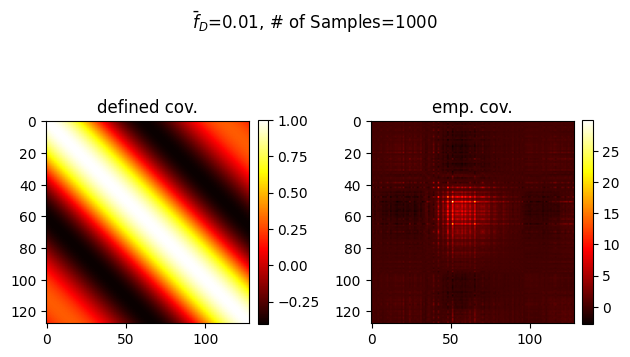

Epoch 3200: KL Div 8.107e-02 G loss 7.109e-02 D loss 6.528e-02:  64

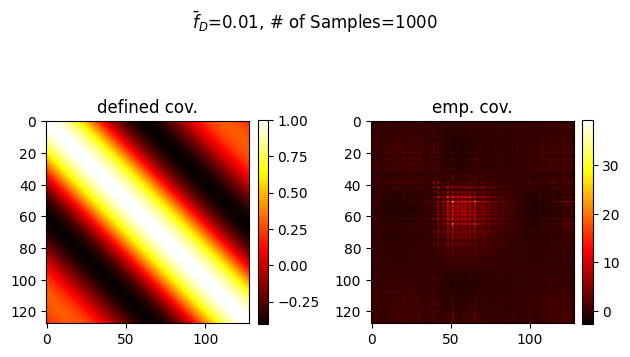

Epoch 3300: KL Div 8.271e-02 G loss 7.634e-02 D loss 4.675e-02:  66

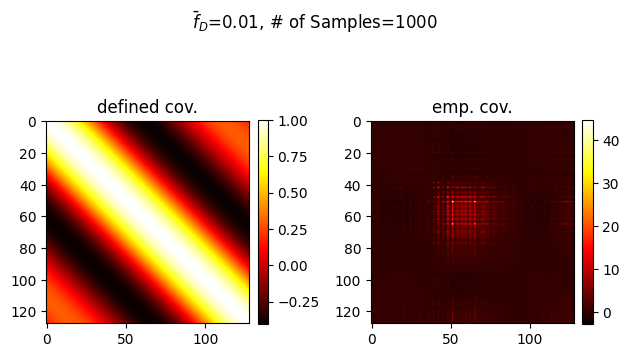

Epoch 3400: KL Div 8.118e-02 G loss 9.407e-02 D loss 6.378e-02:  68

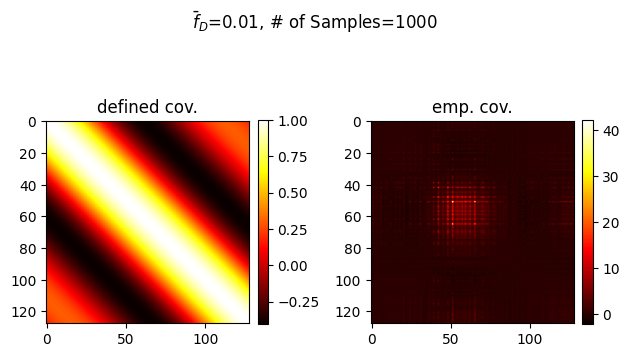

Epoch 3500: KL Div 7.231e-02 G loss 9.410e-02 D loss 6.061e-02:  70

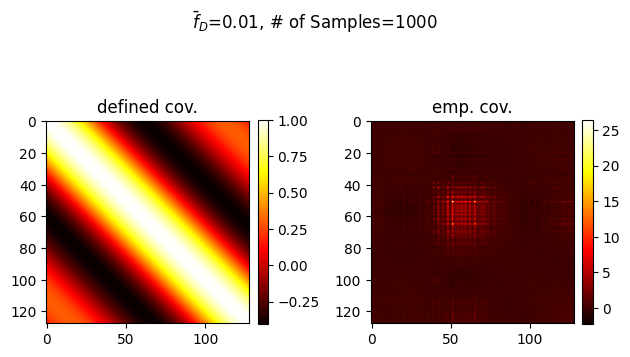

Epoch 3600: KL Div 8.361e-02 G loss 1.343e-01 D loss 1.400e-02:  72

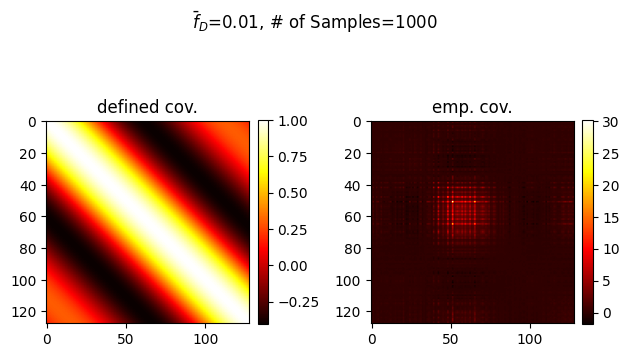

Epoch 3700: KL Div 6.136e-02 G loss 4.409e-02 D loss 5.491e-02:  74

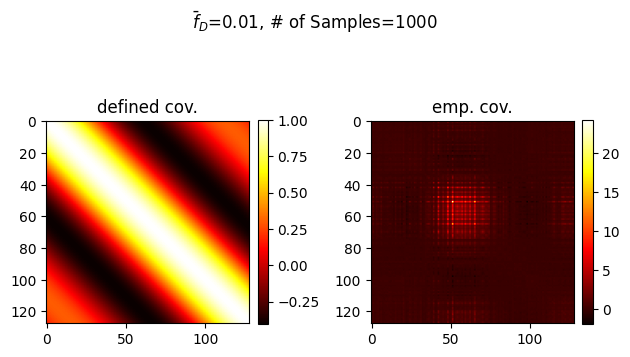

Epoch 3800: KL Div 5.617e-02 G loss 5.805e-02 D loss 6.629e-02:  76

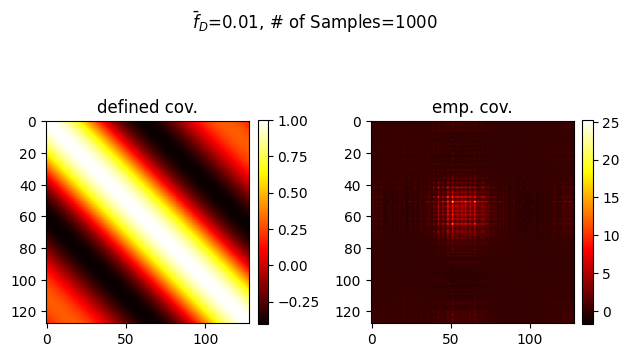

Epoch 3900: KL Div 4.661e-02 G loss 4.644e-02 D loss 6.484e-02:  78

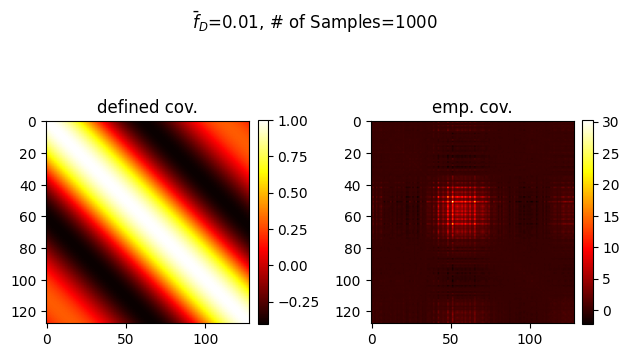

Epoch 4000: KL Div 7.351e-02 G loss 1.637e-01 D loss 6.288e-02:  80

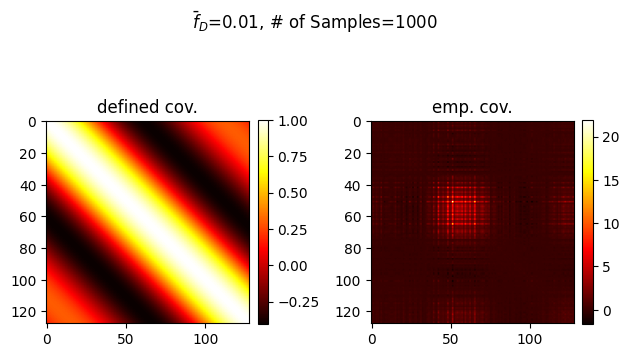

Epoch 4100: KL Div 6.484e-02 G loss 7.460e-02 D loss 6.262e-02:  82

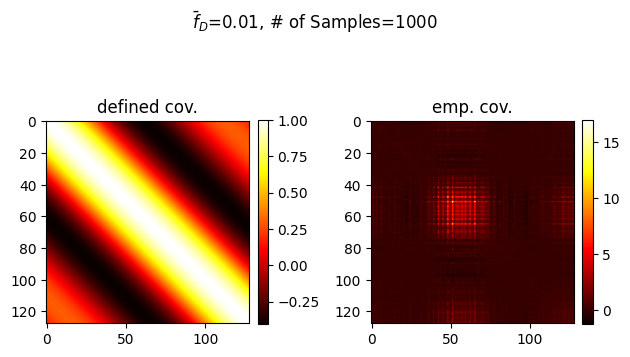

Epoch 4200: KL Div 4.976e-02 G loss 2.404e-02 D loss 7.004e-02:  84

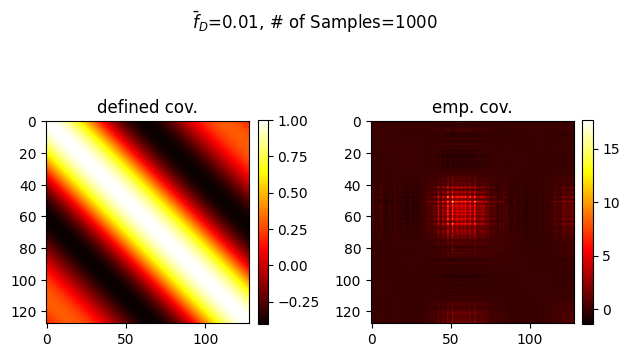

Epoch 4300: KL Div 7.663e-02 G loss 1.016e-01 D loss 6.184e-02:  86

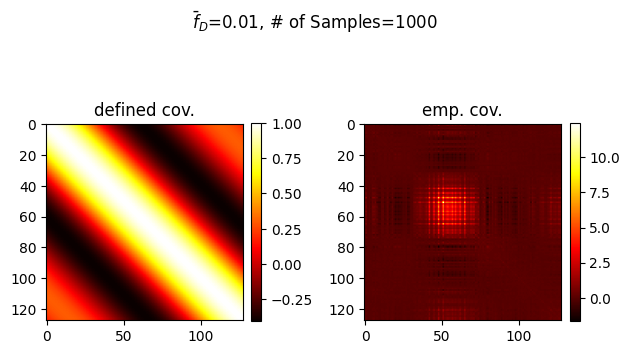

Epoch 4400: KL Div 6.536e-02 G loss -3.858e-02 D loss 7.419e-02:  8

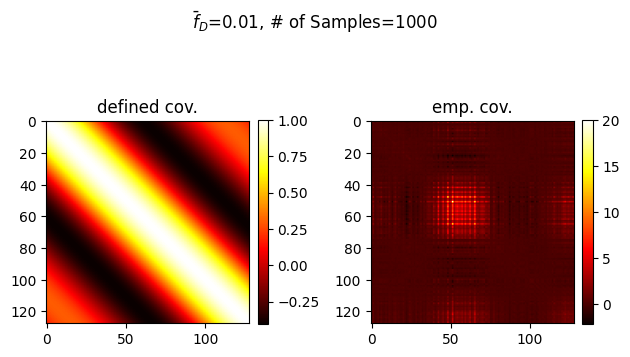

Epoch 4500: KL Div 6.753e-02 G loss 4.502e-02 D loss 6.625e-02:  90

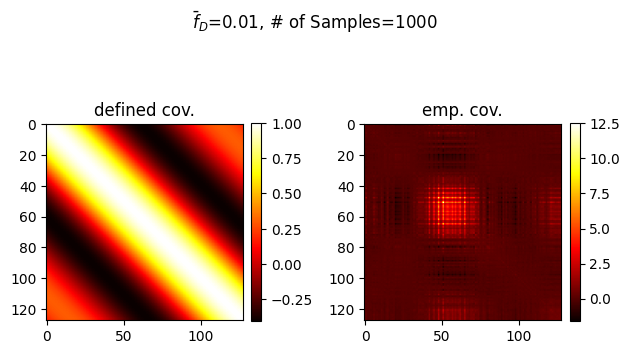

Epoch 4600: KL Div 5.072e-02 G loss -6.875e-02 D loss 6.517e-02:  9

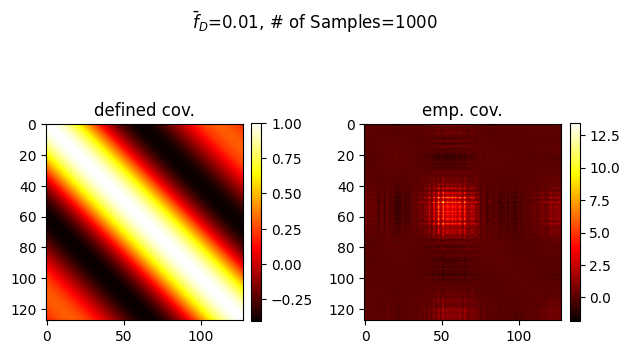

Epoch 4700: KL Div 5.233e-02 G loss -8.441e-02 D loss 5.465e-02:  9

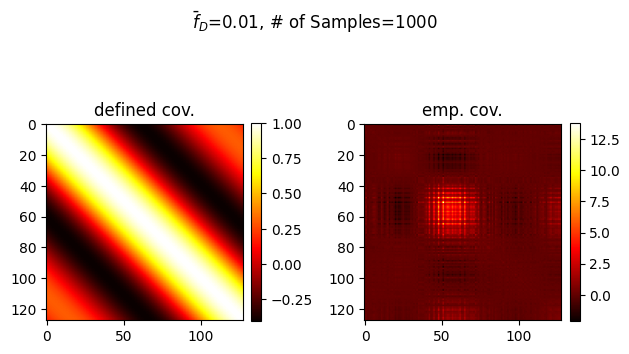

Epoch 4800: KL Div 3.858e-02 G loss -7.974e-02 D loss 7.035e-02:  9

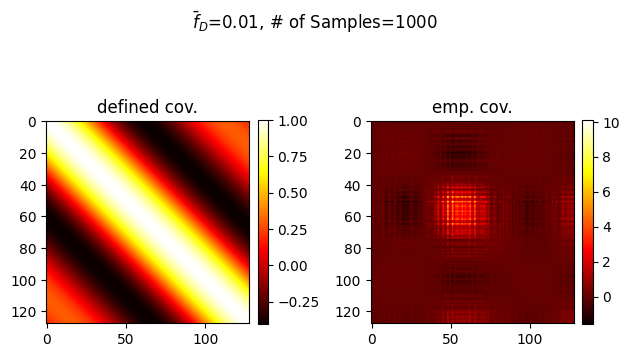

Epoch 4900: KL Div 6.160e-02 G loss -6.823e-02 D loss 6.402e-02:  9

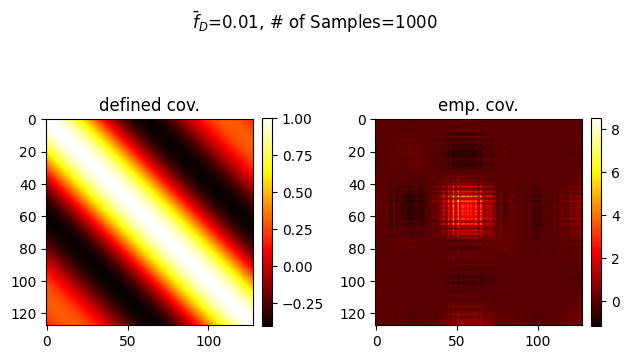

Epoch 5000: KL Div 4.569e-02 G loss 1.881e-03 D loss 6.194e-02: 100

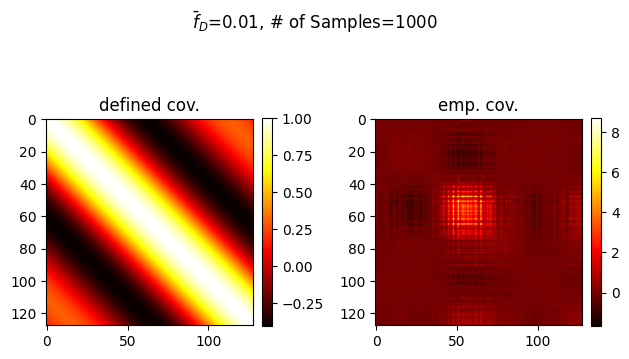

Epoch 5000: KL Div 4.569e-02 G loss 1.881e-03 D loss 6.194e-02: 100


In [28]:
num_epochs = 5000

d_lr = 5e-5
g_lr = 5e-5


with tqdm(initial = step, total=num_epochs, ascii=True) as pbar:  
    while step < num_epochs:
        g_loss, d_loss, kl_loss = WGAN.train_WGAN_CNN(G, D, batch_size, n, channel_model, d_lr, g_lr, is_GP=False)
        
        writer_G.add_scalar('train_loss/g_loss', g_loss, step)
        writer_G.add_scalar('train_loss/kl_loss', kl_loss, step)
        writer_D.add_scalar('train_loss/d_loss', d_loss, step)
        
        pbar.set_description(f"Epoch {step+1}: KL Div {kl_loss:.3e} G loss {-g_loss:.3e} D loss {-d_loss:.3e}")

        #if (step+1) % 1000 == 0:
        #    WGAN.plot_GAN(G, 10000, n, channel_model, step)
        if (step+1) % save_every == 0:
            milestone = (step+1) // save_every 
            torch.save(G.state_dict(), f'{path}/G-{milestone}.pt')
            torch.save(D.state_dict(), f'{path}/D-{milestone}.pt')
    
            _ = compare_empirical_cov(G, Config_ch, num_samples = 10 **3, milestone=milestone)
       
        step += 1
        pbar.update(1)
        

Epoch 5100: KL Div 5.035e-02 G loss -1.411e-02 D loss 6.653e-02:  5

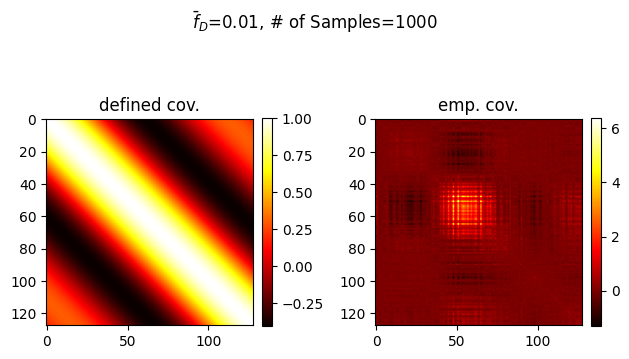

Epoch 5200: KL Div 4.543e-02 G loss -8.522e-02 D loss 4.009e-02:  5

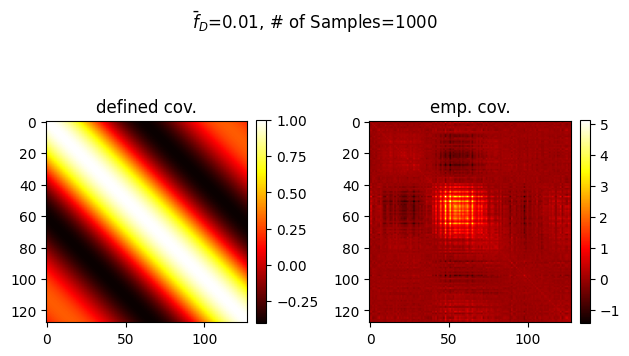

Epoch 5300: KL Div 7.722e-02 G loss 4.175e-02 D loss 7.911e-02:  53

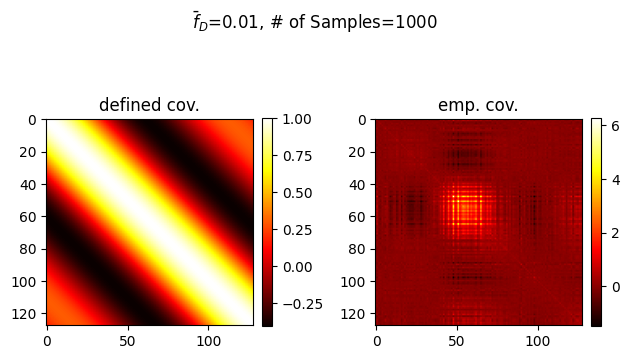

Epoch 5400: KL Div 4.911e-02 G loss -8.046e-03 D loss 5.982e-02:  5

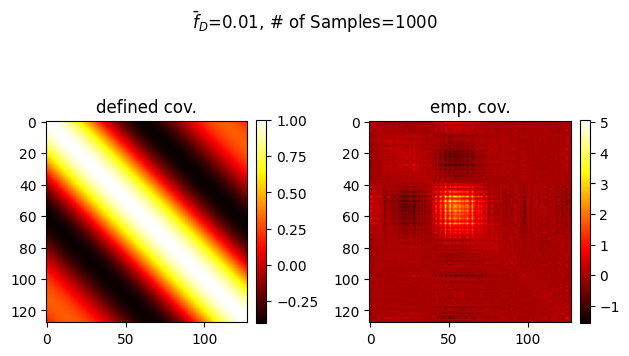

Epoch 5500: KL Div 4.048e-02 G loss -4.597e-02 D loss 4.976e-02:  5

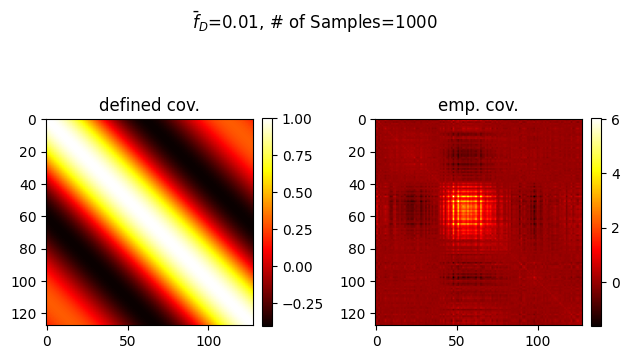

Epoch 5600: KL Div 5.511e-02 G loss -9.686e-03 D loss 6.631e-02:  5

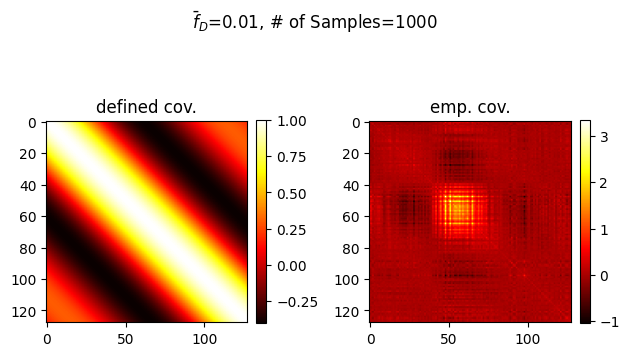

Epoch 5700: KL Div 5.227e-02 G loss -3.968e-02 D loss 7.169e-02:  5

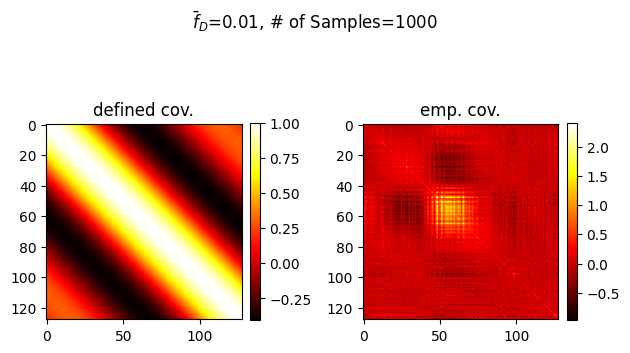

Epoch 5800: KL Div 3.641e-02 G loss -1.229e-01 D loss 5.218e-02:  5

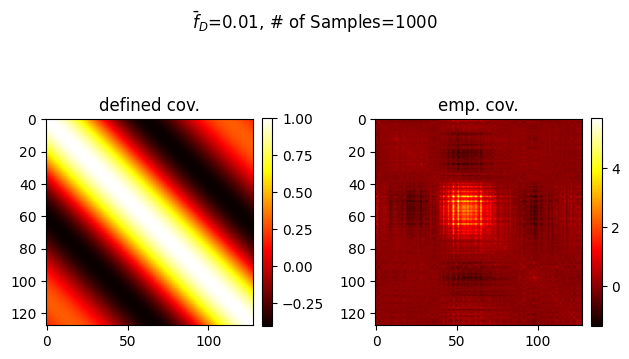

Epoch 5900: KL Div 4.927e-02 G loss -1.000e-01 D loss 6.709e-02:  5

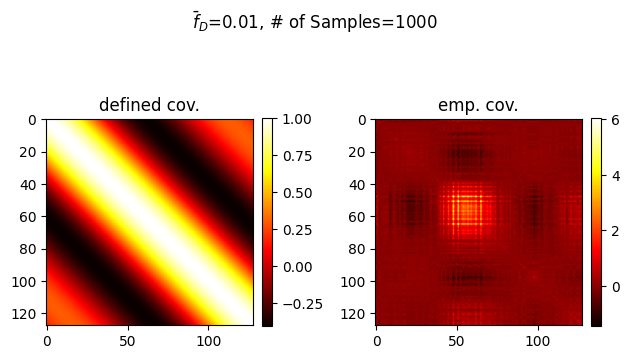

Epoch 6000: KL Div 4.664e-02 G loss -6.568e-02 D loss 7.082e-02:  6

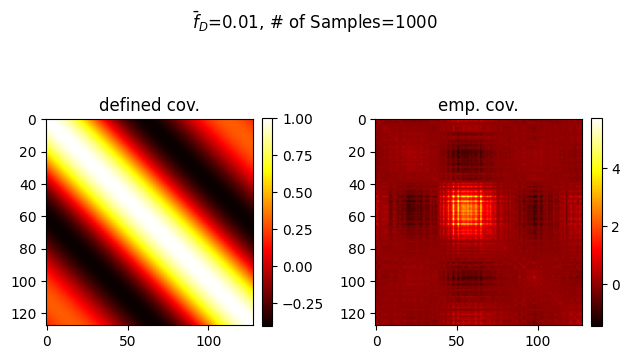

Epoch 6100: KL Div 5.102e-02 G loss -9.578e-02 D loss 6.664e-02:  6

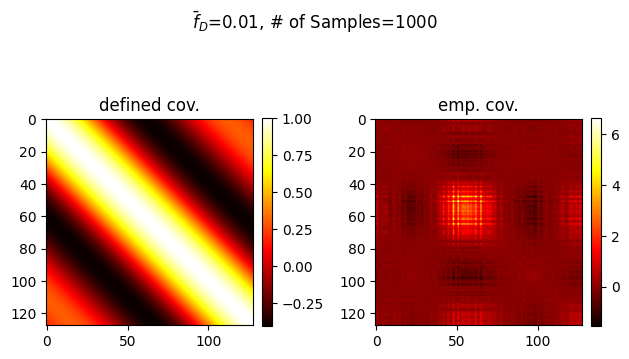

Epoch 6200: KL Div 6.707e-02 G loss 4.678e-03 D loss 7.228e-02:  62

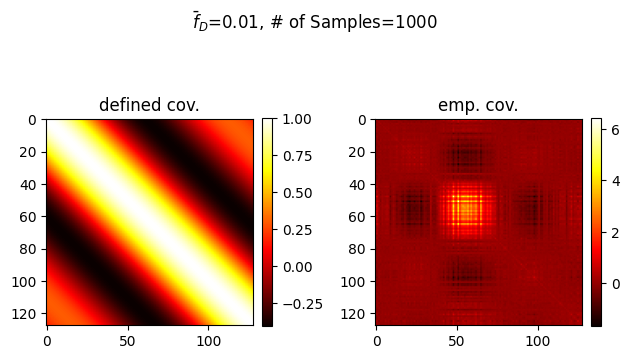

Epoch 6300: KL Div 5.778e-02 G loss -2.134e-02 D loss 7.094e-02:  6

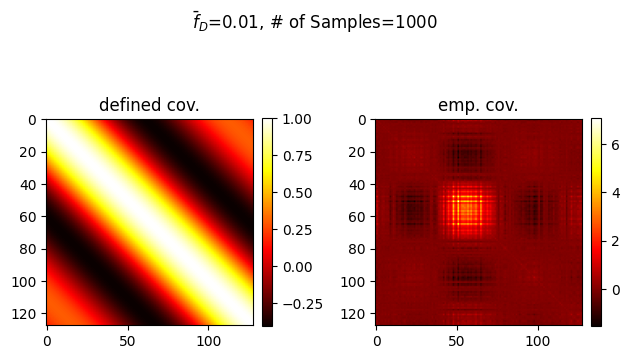

Epoch 6400: KL Div 6.391e-02 G loss 3.110e-02 D loss 6.597e-02:  64

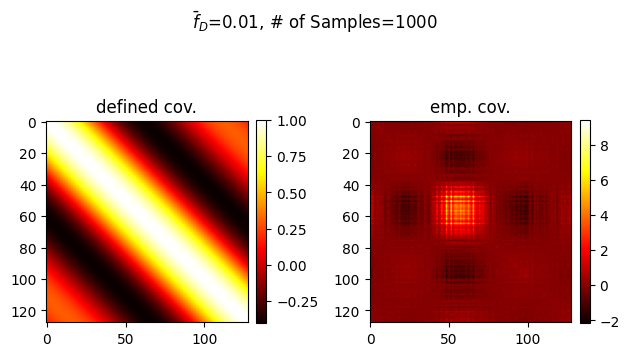

Epoch 6500: KL Div 4.928e-02 G loss -7.541e-02 D loss 6.450e-02:  6

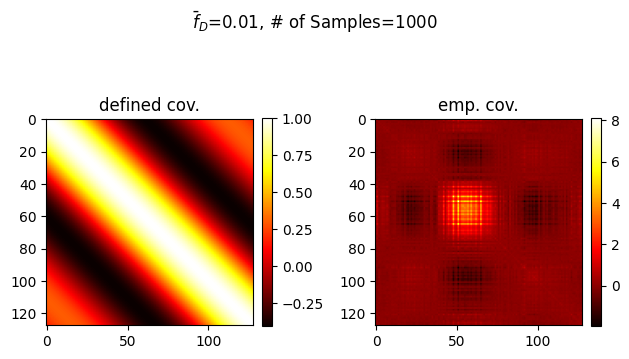

Epoch 6600: KL Div 3.905e-02 G loss -1.093e-01 D loss 6.706e-02:  6

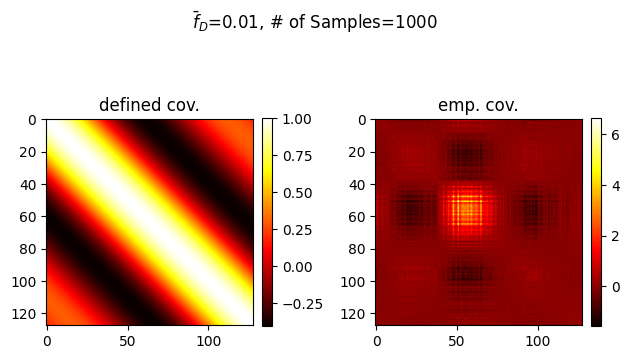

Epoch 6700: KL Div 4.085e-02 G loss -8.769e-02 D loss 7.000e-02:  6

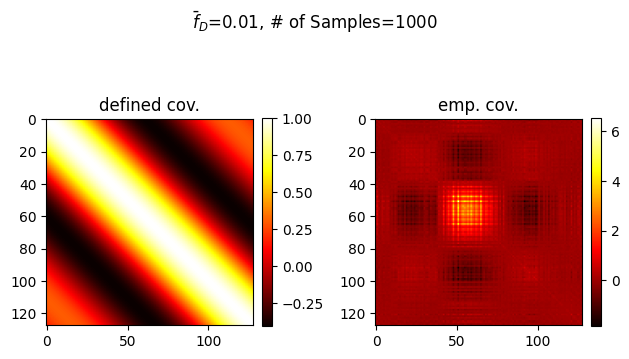

Epoch 6800: KL Div 4.339e-02 G loss -4.084e-02 D loss 6.463e-02:  6

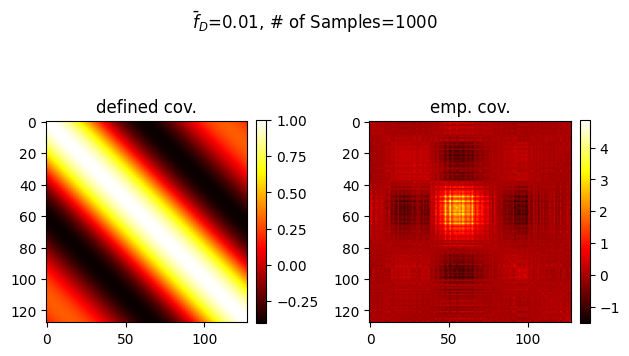

Epoch 6900: KL Div 6.138e-02 G loss 3.180e-02 D loss 6.732e-02:  69

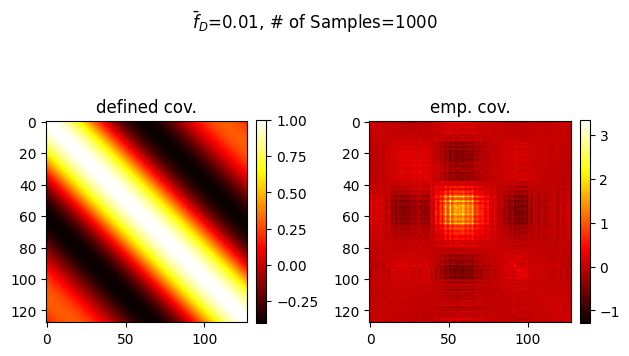

Epoch 7000: KL Div 4.001e-02 G loss -5.321e-02 D loss 7.486e-02:  7

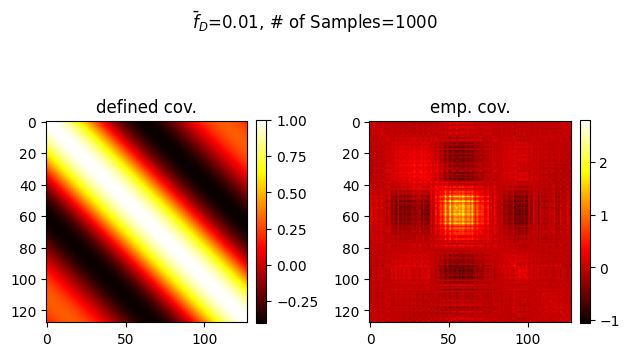

Epoch 7100: KL Div 6.614e-02 G loss 2.099e-02 D loss 7.286e-02:  71

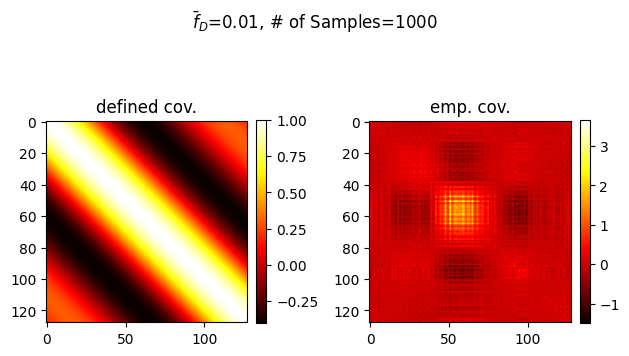

Epoch 7200: KL Div 5.805e-02 G loss -3.678e-02 D loss 7.015e-02:  7

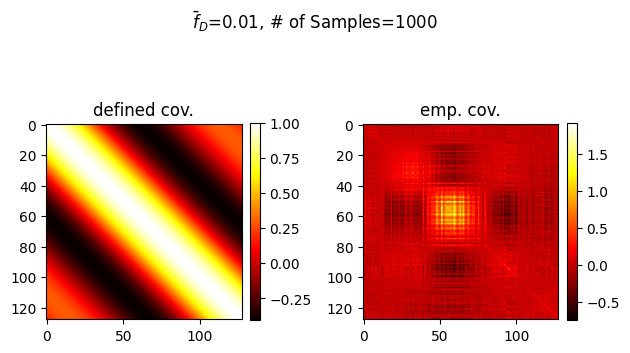

Epoch 7300: KL Div 5.334e-02 G loss -3.026e-02 D loss 3.993e-02:  7

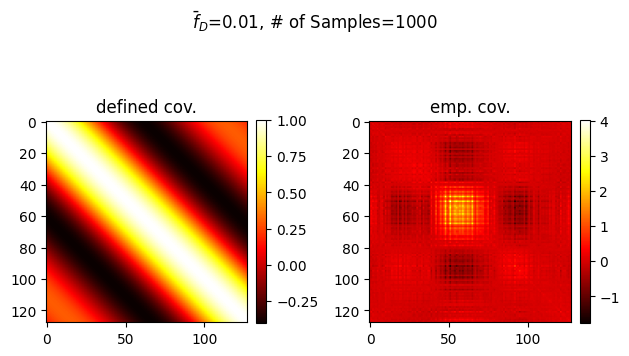

Epoch 7400: KL Div 4.352e-02 G loss -4.184e-03 D loss 6.159e-02:  7

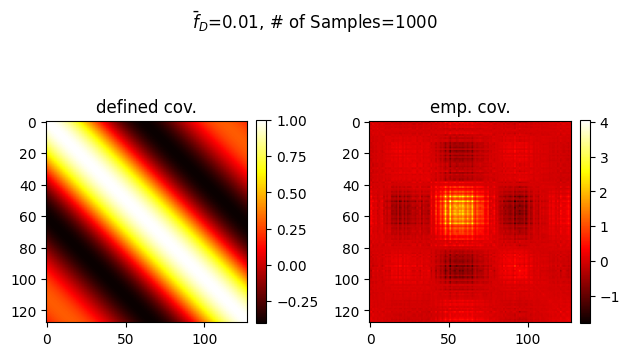

Epoch 7500: KL Div 5.131e-02 G loss -1.575e-02 D loss 6.962e-02:  7

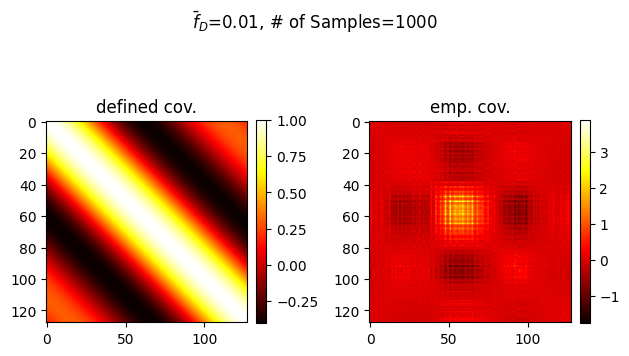

Epoch 7600: KL Div 4.442e-02 G loss -8.368e-02 D loss 6.339e-02:  7

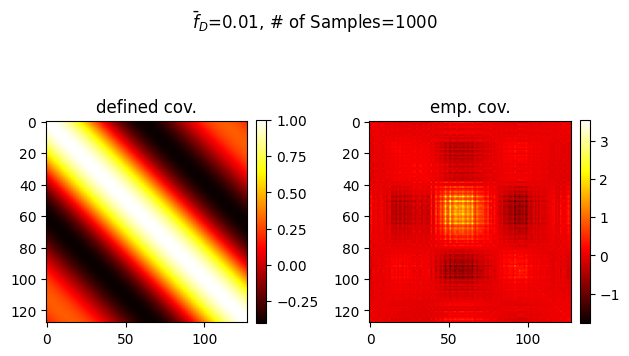

Epoch 7700: KL Div 4.901e-02 G loss -1.268e-01 D loss 5.888e-02:  7

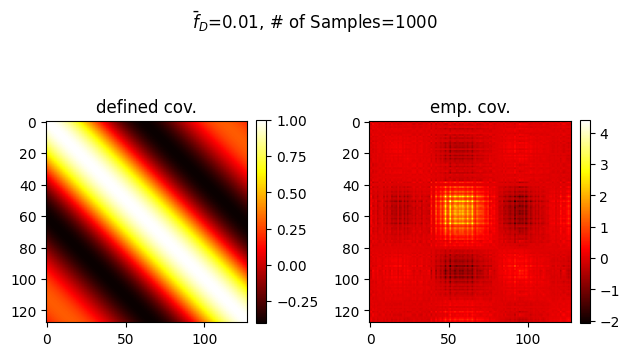

Epoch 7800: KL Div 6.272e-02 G loss 2.071e-02 D loss 6.752e-02:  78

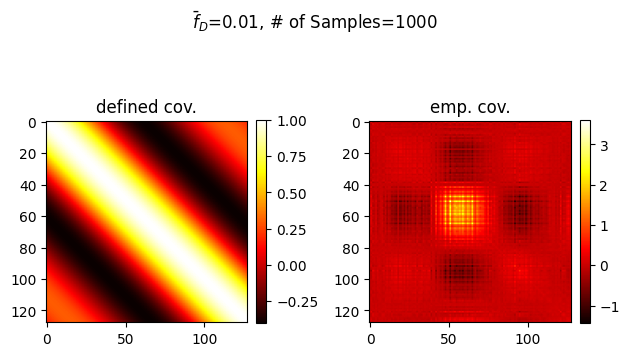

Epoch 7900: KL Div 4.341e-02 G loss -1.174e-02 D loss 7.158e-02:  7

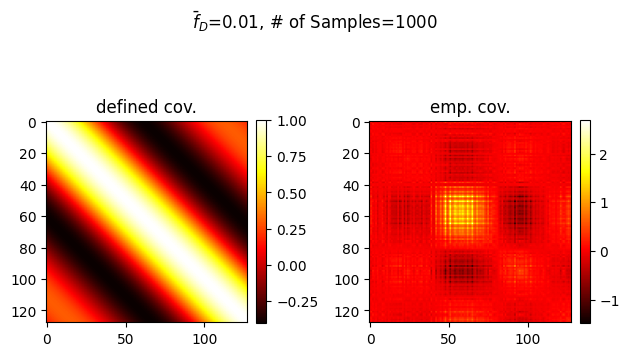

Epoch 8000: KL Div 2.660e-02 G loss -1.174e-01 D loss 6.876e-02:  8

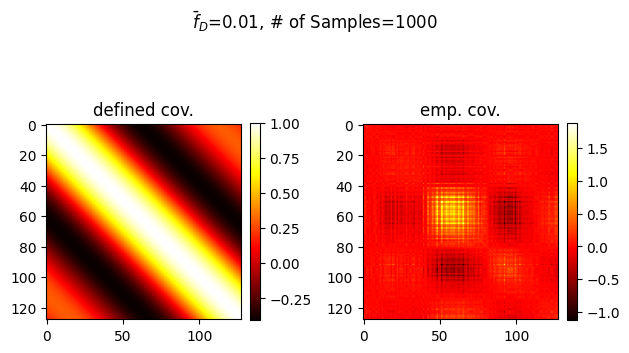

Epoch 8100: KL Div 4.719e-02 G loss -6.123e-02 D loss 6.352e-02:  8

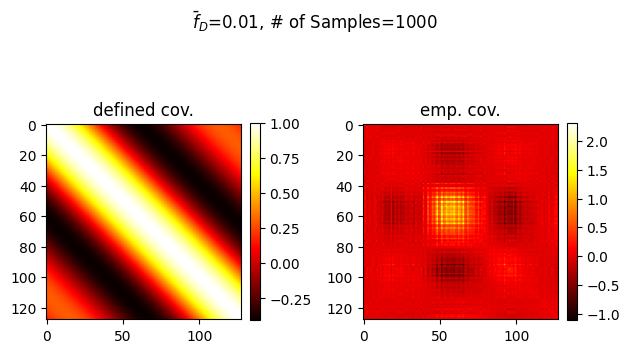

Epoch 8200: KL Div 3.837e-02 G loss -8.060e-02 D loss 6.571e-02:  8

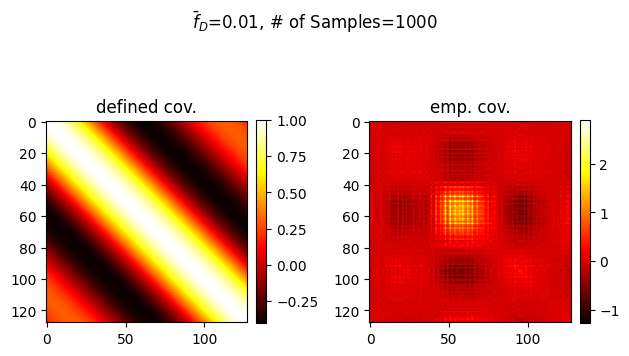

Epoch 8300: KL Div 3.381e-02 G loss 6.258e-02 D loss 7.301e-02:  83

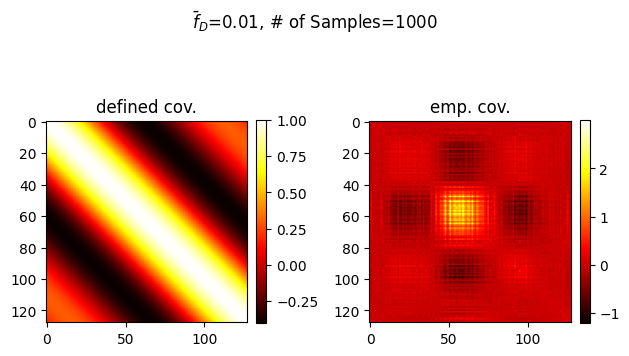

Epoch 8400: KL Div 4.120e-02 G loss -4.312e-02 D loss 7.436e-02:  8

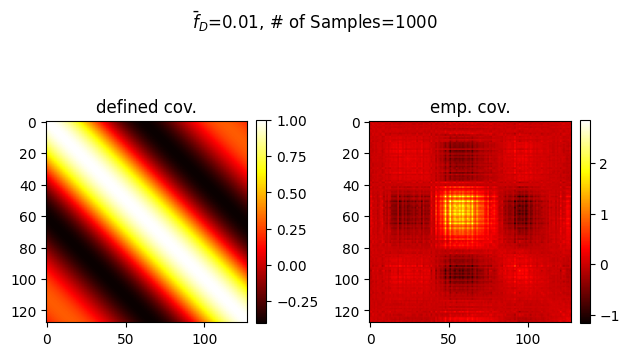

Epoch 8500: KL Div 3.988e-02 G loss -2.403e-03 D loss 4.278e-02:  8

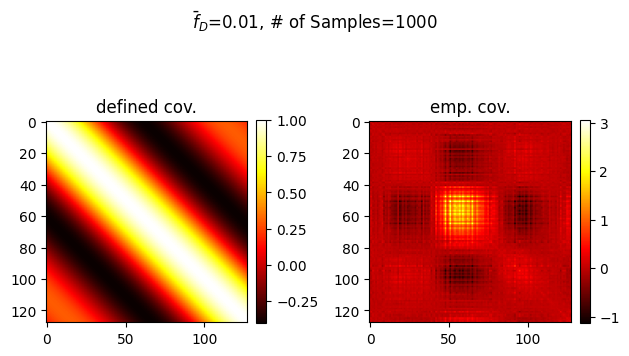

Epoch 8600: KL Div 3.021e-02 G loss -4.621e-02 D loss 6.133e-02:  8

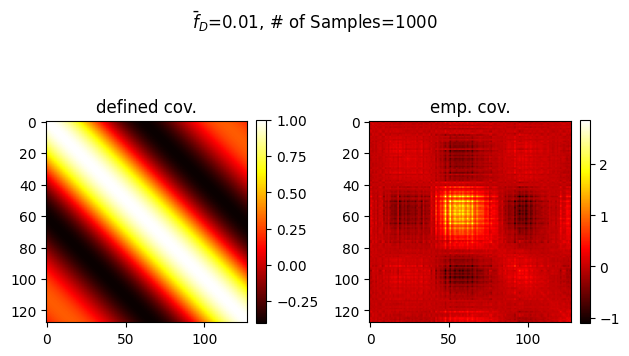

Epoch 8700: KL Div 4.979e-02 G loss -4.057e-02 D loss 7.216e-02:  8

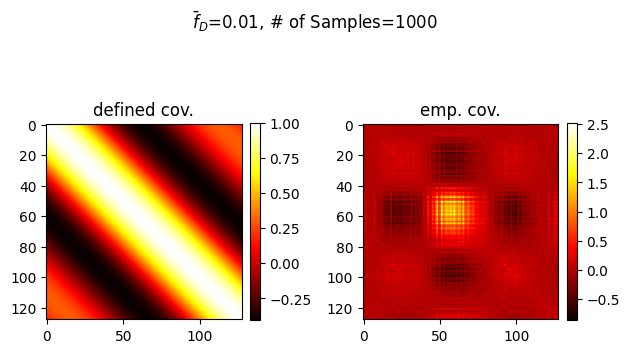

Epoch 8800: KL Div 5.295e-02 G loss -1.528e-01 D loss 6.961e-02:  8

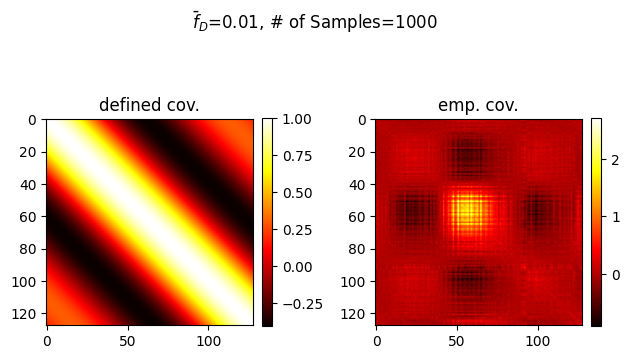

Epoch 8900: KL Div 4.416e-02 G loss -1.076e-01 D loss 6.423e-02:  8

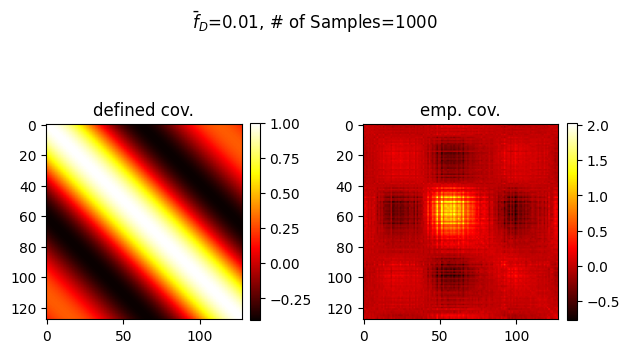

Epoch 9000: KL Div 5.175e-02 G loss 3.962e-02 D loss 5.801e-02:  90

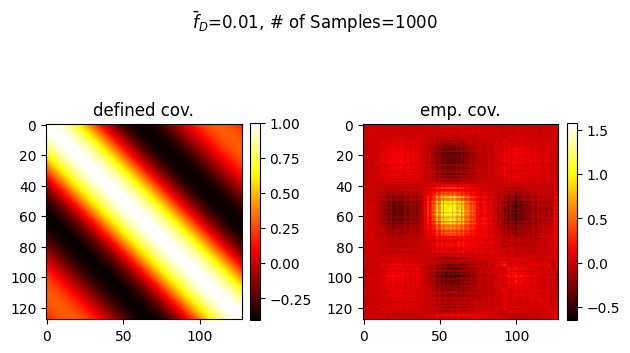

Epoch 9100: KL Div 6.551e-02 G loss -2.109e-02 D loss 6.905e-02:  9

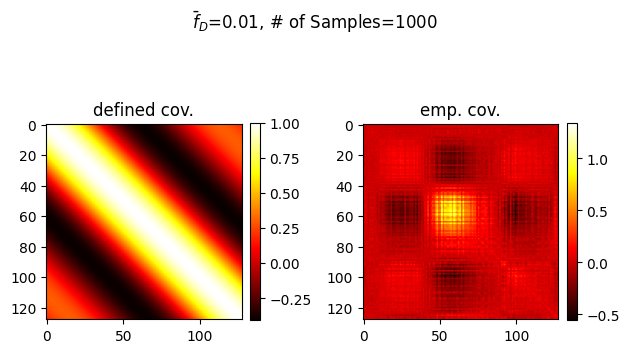

Epoch 9200: KL Div 3.893e-02 G loss -1.079e-01 D loss 7.120e-02:  9

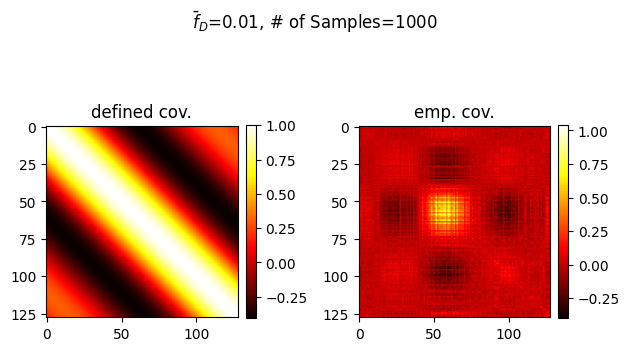

Epoch 9300: KL Div 4.467e-02 G loss -1.207e-01 D loss 4.671e-02:  9

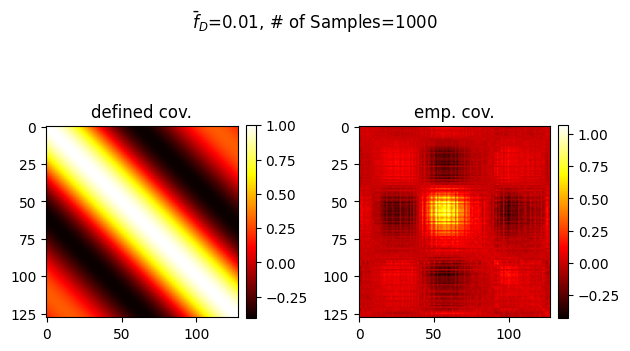

Epoch 9400: KL Div 6.306e-02 G loss -2.734e-02 D loss 6.849e-02:  9

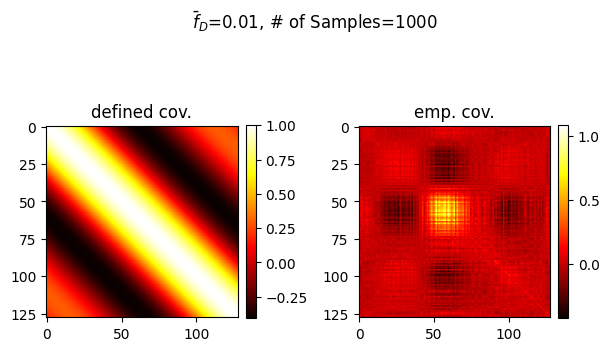

Epoch 9500: KL Div 4.925e-02 G loss -2.060e-02 D loss 6.590e-02:  9

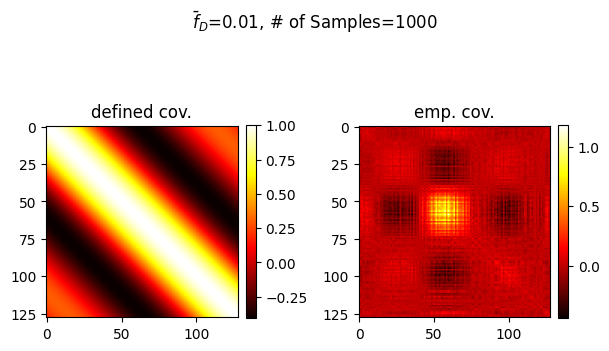

Epoch 9600: KL Div 4.401e-02 G loss -5.394e-02 D loss 7.072e-02:  9

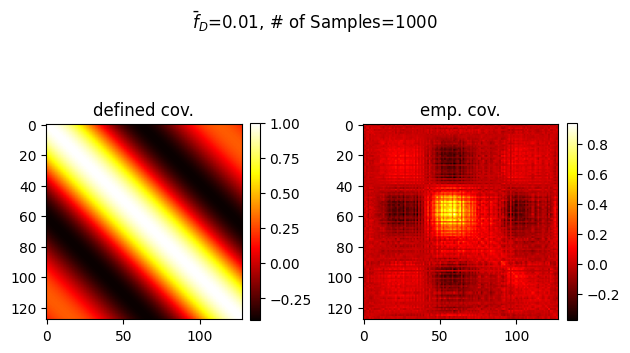

Epoch 9700: KL Div 4.286e-02 G loss -3.052e-02 D loss 6.835e-02:  9

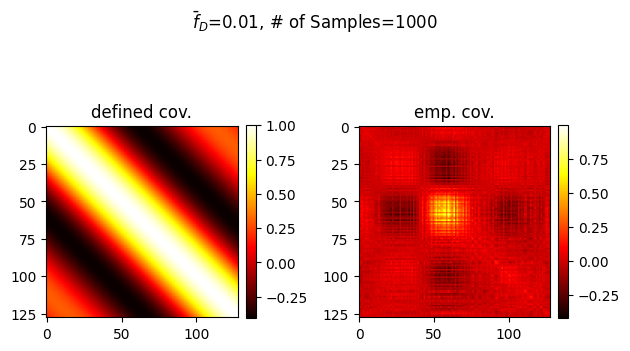

Epoch 9800: KL Div 3.653e-02 G loss -8.050e-03 D loss 5.965e-02:  9

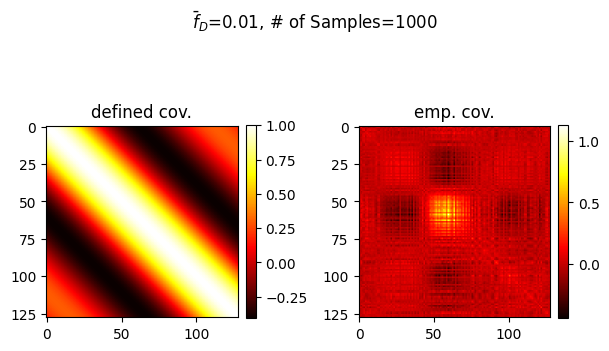

Epoch 9900: KL Div 5.322e-02 G loss -8.208e-02 D loss 7.549e-02:  9

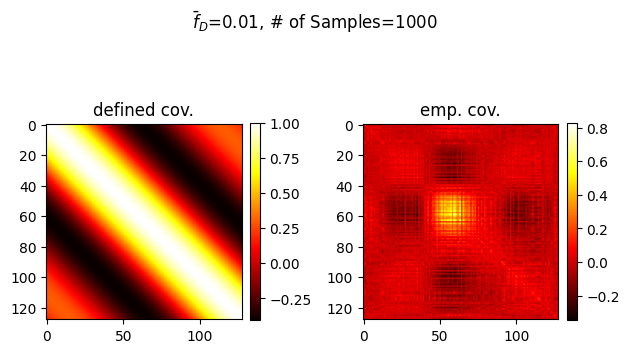

Epoch 10000: KL Div 5.132e-02 G loss 4.254e-02 D loss 3.753e-02: 10

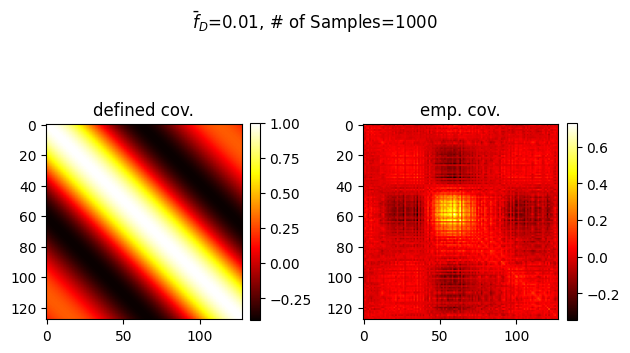

Epoch 10000: KL Div 5.132e-02 G loss 4.254e-02 D loss 3.753e-02: 10


In [29]:
num_epochs = 10000

d_lr = 5e-5
g_lr = 5e-5


with tqdm(initial = step, total=num_epochs, ascii=True) as pbar:  
    while step < num_epochs:
        g_loss, d_loss, kl_loss = WGAN.train_WGAN_CNN(G, D, batch_size, n, channel_model, d_lr, g_lr, is_GP=False)
        
        writer_G.add_scalar('train_loss/g_loss', g_loss, step)
        writer_G.add_scalar('train_loss/kl_loss', kl_loss, step)
        writer_D.add_scalar('train_loss/d_loss', d_loss, step)
        
        pbar.set_description(f"Epoch {step+1}: KL Div {kl_loss:.3e} G loss {-g_loss:.3e} D loss {-d_loss:.3e}")

        #if (step+1) % 1000 == 0:
        #    WGAN.plot_GAN(G, 10000, n, channel_model, step)
        if (step+1) % save_every == 0:
            milestone = (step+1) // save_every 
            torch.save(G.state_dict(), f'{path}/G-{milestone}.pt')
            torch.save(D.state_dict(), f'{path}/D-{milestone}.pt')
    
            _ = compare_empirical_cov(G, Config_ch, num_samples = 10 **3, milestone=milestone)
       
        step += 1
        pbar.update(1)
        

## Evaluation: empirical covariance and sliced Wasserstein distance

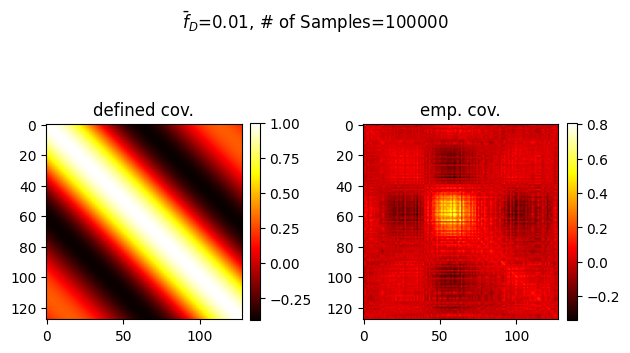

In [27]:
generated_h = compare_empirical_cov(G, Config_ch, num_samples = 10 **5, milestone=milestone)


In [28]:
num_samples = 10**5
bs = 100

# Compute a matrix A such that A*A^H = Cov.
        
# Compute the Cholesky decomposition.
A = torch.linalg.cholesky(Config_ch.cov, upper=False)  # torch.cholesky(Cov, upper=False)
# print(torch.mm(A, A.conj().T))
# print(Cov_h)
A = A[None, :, :].repeat(bs, 1, 1).to(device)
h_t = torch.zeros(num_samples, 2*n)

for i in range(num_samples // bs):
    # generate normally distributed matrices
    h = torch.normal(mean=0., std=1., size=(bs, n), device=device, dtype=torch.cfloat)
    h = h[:, :, None]
    # Correlated channel matrices h = Ah,  A[n,n] h[n, 1]
    h = torch.bmm(A, h)
    h = h.view(bs, n)
    h_t[bs*i:bs*(i+1),:] = torch.view_as_real(h).view(-1,2*n).contiguous()
    

In [30]:
generated_h_t = torch.transpose(generated_h, 1,2).contiguous().view(-1,2*n) # After taking transpose, it's necessary. 

wasserstein_distance = _sliced_wasserstein(generated_h_t, h_t, 128)
print(wasserstein_distance)

0.8949635
